In [1]:
# Mount Google Drive to access dataset stored on Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import necessary libraries for data handling, plotting, and model training
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
# Define the paths to your train and test dataset in Google Drive
train_data_path = '/content/drive/My Drive/archive/train.csv'
test_data_path = '/content/drive/My Drive/archive/test.csv'

# Load the training and testing datasets
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

In [4]:
# Display basic information about the datasets
print("Train Data Info:")
print(train_data.info())
print("Test Data Info:")
print(test_data.info())

Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 31.6+ MB
None
Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2947 entries, 0 to 2946
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 12.7+ MB
None


In [5]:
# Split the dataset into features (X) and labels (y) for both train and test sets
X_train = train_data.drop(columns=['Activity'])
y_train = train_data['Activity']
X_test = test_data.drop(columns=['Activity'])
y_test = test_data['Activity']

In [6]:
# Map activity names to numeric labels
activity_mapping = {
    'LAYING': 0,
    'WALKING': 1,
    'WALKING_UPSTAIRS': 2,
    'WALKING_DOWNSTAIRS': 3,
    'SITTING': 4,
    'STANDING': 5
}

In [7]:
# Apply the mapping to the training and testing labels
y_train = y_train.map(activity_mapping)
y_test = y_test.map(activity_mapping)

In [8]:
# Convert labels to categorical format
y_train = keras.utils.to_categorical(y_train, num_classes=6)
y_test = keras.utils.to_categorical(y_test, num_classes=6)

In [9]:
# Reshape the data to 3D format (samples, timesteps, features) required by LSTM
X_train_lstm = X_train.values.reshape(-1, 1, X_train.shape[1])
X_test_lstm = X_test.values.reshape(-1, 1, X_test.shape[1])

In [10]:
# Initialize Stratified K-Fold Cross-Validation with 3 folds
n_splits = 3
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [11]:
# Placeholder arrays to store predictions for each fold and final test predictions
valid_preds = np.zeros((X_train.shape[0], 6))
test_preds = np.zeros((n_splits, X_test.shape[0], 6))

In [12]:
# Early stopping to prevent overfitting, and learning rate reduction on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6)

In [13]:
# Initialize variables to track performance metrics
train_loss_per_fold = []
val_loss_per_fold = []
train_acc_per_fold = []
val_acc_per_fold = []
best_val_acc = 0
best_fold_id = -1
best_fold_predictions = None  # To store predictions from the best fold

In [14]:
# Iterate through each fold in the cross-validation
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train, np.argmax(y_train, axis=1))):
    # Split data into training and validation sets
    X_tr = X_train_lstm[train_index]
    X_val = X_train_lstm[valid_index]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    print(f"Fold {fold_id}: X_tr shape: {X_tr.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test_lstm.shape}")

    # Build the LSTM model
    model = keras.Sequential([
        LSTM(128, activation='relu', input_shape=(X_tr.shape[1], X_tr.shape[2]), return_sequences=True),
        Dropout(0.5),
        LSTM(64, activation='relu'),
        Dropout(0.5),
        Dense(6, activation='softmax')  # Output layer with 6 classes
    ])

    # Compile the model with Adam optimizer and categorical cross-entropy loss
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model on the training fold
    history = model.fit(X_tr, y_tr, epochs=50, batch_size=64, validation_data=(X_val, y_val), verbose=1,
                        callbacks=[early_stopping, reduce_lr])

    # Track loss and accuracy for each fold
    train_loss_per_fold.append(history.history['loss'])
    val_loss_per_fold.append(history.history['val_loss'])
    train_acc_per_fold.append(history.history['accuracy'])
    val_acc_per_fold.append(history.history['val_accuracy'])

    # Evaluate on validation set
    val_preds = model.predict(X_val)
    valid_preds[valid_index] = val_preds
    test_preds[fold_id] = model.predict(X_test_lstm)

    # Calculate validation accuracy
    val_pred_classes = val_preds.argmax(axis=1)
    y_val_classes = y_val.argmax(axis=1)
    val_accuracy = accuracy_score(y_val_classes, val_pred_classes)

    # Keep track of the best validation accuracy and corresponding fold
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        best_fold_id = fold_id
        best_fold_predictions = val_preds
        best_y_val_classes = y_val_classes

Fold 0: X_tr shape: (4901, 1, 562), X_val shape: (2451, 1, 562), X_test shape: (2947, 1, 562)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.3120 - loss: 1.5356 - val_accuracy: 0.7483 - val_loss: 0.6961 - learning_rate: 0.0010
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6493 - loss: 0.7737 - val_accuracy: 0.8650 - val_loss: 0.3518 - learning_rate: 0.0010
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7794 - loss: 0.5166 - val_accuracy: 0.9143 - val_loss: 0.2704 - learning_rate: 0.0010
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8201 - loss: 0.3934 - val_accuracy: 0.9278 - val_loss: 0.2188 - learning_rate: 0.0010
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8489 - loss: 0.3556 - val_accuracy: 0.9306 - val_loss: 0.1968 - learning_rate: 0.0010
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8685 - loss: 0.3176 - val_accuracy: 0.9266 - val_loss: 0.1753 - learning_rate: 0.0010
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8882 - loss: 0.2794 - val_acc

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.3421 - loss: 1.4481 - val_accuracy: 0.7654 - val_loss: 0.6254 - learning_rate: 0.0010
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6775 - loss: 0.7346 - val_accuracy: 0.8817 - val_loss: 0.3381 - learning_rate: 0.0010
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7871 - loss: 0.4764 - val_accuracy: 0.8907 - val_loss: 0.2823 - learning_rate: 0.0010
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8322 - loss: 0.3879 - val_accuracy: 0.9286 - val_loss: 0.2061 - learning_rate: 0.0010
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8661 - loss: 0.3225 - val_accuracy: 0.9266 - val_loss: 0.1792 - learning_rate: 0.0010
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8905 - loss: 0.2746 - val_accuracy: 0.9323 - val_loss: 0.1604 - learning_rate: 0.0010
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8978 - loss: 0.2583 - val_accuracy: 0.94

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.3087 - loss: 1.5012 - val_accuracy: 0.7869 - val_loss: 0.6955 - learning_rate: 0.0010
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6585 - loss: 0.7802 - val_accuracy: 0.8690 - val_loss: 0.3837 - learning_rate: 0.0010
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7651 - loss: 0.5253 - val_accuracy: 0.8959 - val_loss: 0.2829 - learning_rate: 0.0010
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8370 - loss: 0.3925 - val_accuracy: 0.9135 - val_loss: 0.2315 - learning_rate: 0.0010
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8572 - loss: 0.3520 - val_accuracy: 0.9318 - val_loss: 0.2033 - learning_rate: 0.0010
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8866 - loss: 0.2840 - val_accuracy: 0.9371 - val_loss: 0.1673 - learning_rate: 0.0010
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8942 - loss: 0.2631 - val_accuracy: 0.94

In [15]:
# Print classification report for the best fold based on validation accuracy
print("Classification Report for the Best Fold:")
best_fold_pred_classes = best_fold_predictions.argmax(axis=1)
print(classification_report(best_y_val_classes, best_fold_pred_classes, target_names=activity_mapping.keys()))

Classification Report for the Best Fold:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       469
           WALKING       1.00      1.00      1.00       409
  WALKING_UPSTAIRS       1.00      0.99      1.00       358
WALKING_DOWNSTAIRS       0.99      1.00      1.00       328
           SITTING       0.93      0.96      0.95       429
          STANDING       0.96      0.93      0.95       458

          accuracy                           0.98      2451
         macro avg       0.98      0.98      0.98      2451
      weighted avg       0.98      0.98      0.98      2451



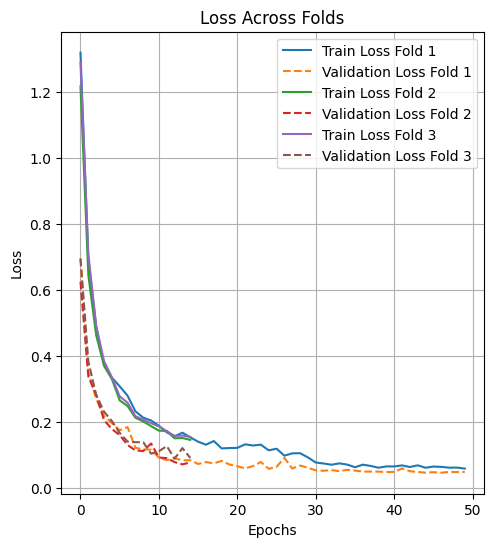

In [16]:
# Plot training and validation loss/accuracy curves
plt.figure(figsize=(12, 6))

# Loss Curve
plt.subplot(1, 2, 1)  # Subplot for Loss
for i in range(n_splits):
    plt.plot(train_loss_per_fold[i], label=f'Train Loss Fold {i+1}')
    plt.plot(val_loss_per_fold[i], label=f'Validation Loss Fold {i+1}', linestyle='--')
plt.title('Loss Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

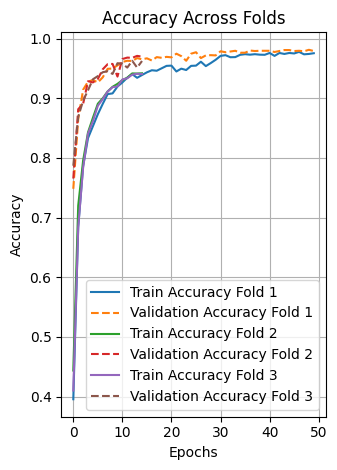

In [17]:
# Accuracy Curve
plt.subplot(1, 2, 2)  # Subplot for Accuracy
for i in range(n_splits):
    plt.plot(train_acc_per_fold[i], label=f'Train Accuracy Fold {i+1}')
    plt.plot(val_acc_per_fold[i], label=f'Validation Accuracy Fold {i+1}', linestyle='--')
plt.title('Accuracy Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()  # To prevent overlap
plt.show()

In [18]:
# Average predictions across all folds for the test set
test_predictions = test_preds.mean(axis=0)
test_pred_classes = test_predictions.argmax(axis=1)

In [19]:
# Calculate test accuracy
test_accuracy = accuracy_score(y_test.argmax(axis=1), test_pred_classes)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Generate classification report for the test set
print("\nClassification Report for the Test Set:")
print(classification_report(y_test.argmax(axis=1), test_pred_classes, target_names=activity_mapping.keys()))

Test Accuracy: 0.9389

Classification Report for the Test Set:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           WALKING       0.92      0.97      0.95       496
  WALKING_UPSTAIRS       0.96      0.93      0.94       471
WALKING_DOWNSTAIRS       0.97      0.94      0.95       420
           SITTING       0.96      0.82      0.89       491
          STANDING       0.85      0.97      0.91       532

          accuracy                           0.94      2947
         macro avg       0.94      0.94      0.94      2947
      weighted avg       0.94      0.94      0.94      2947



In [20]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

# Calculate test accuracy
test_accuracy = accuracy_score(y_test.argmax(axis=1), test_pred_classes)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Generate classification report for the test set
print("\nClassification Report for the Test Set:")

# Generate the classification report as a dictionary
report = classification_report(y_test.argmax(axis=1), test_pred_classes, target_names=activity_mapping.keys(), output_dict=True)

# Convert the classification report dictionary to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Print the classification report in a tabular format with line separations
print("\n" + "-"*60)  # Separator line
print(report_df.to_string(index=True))
print("-" * 60)  # Separator line


Test Accuracy: 0.9389

Classification Report for the Test Set:

------------------------------------------------------------
                    precision    recall  f1-score      support
LAYING               1.000000  0.996276  0.998134   537.000000
WALKING              0.919847  0.971774  0.945098   496.000000
WALKING_UPSTAIRS     0.956236  0.927813  0.941810   471.000000
WALKING_DOWNSTAIRS   0.965686  0.938095  0.951691   420.000000
SITTING              0.961814  0.820774  0.885714   491.000000
STANDING             0.854305  0.969925  0.908451   532.000000
accuracy             0.938921  0.938921  0.938921     0.938921
macro avg            0.942981  0.937443  0.938483  2947.000000
weighted avg         0.941961  0.938921  0.938667  2947.000000
------------------------------------------------------------


Text(0.5, 1.0, 'Confusion Matrix for Test Set')

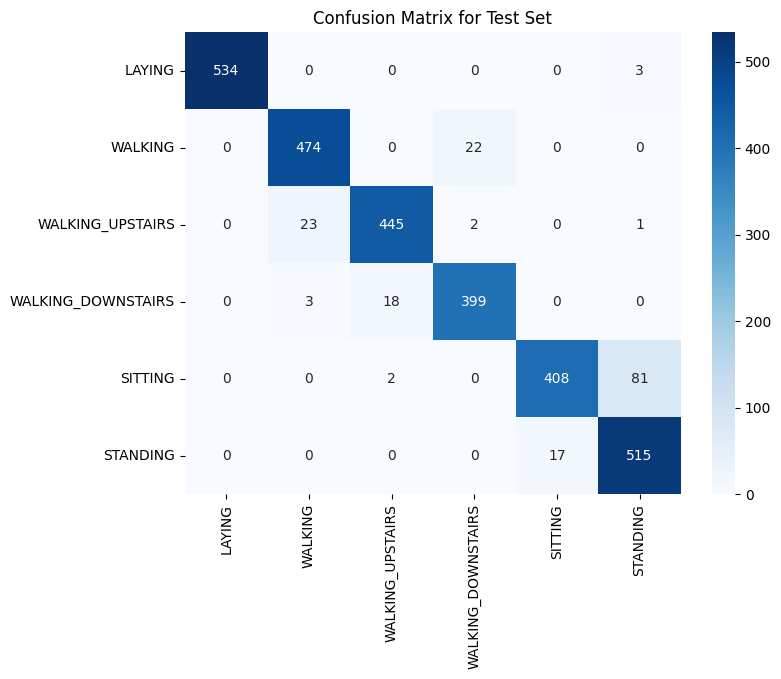

In [ ]:
# Generate and display confusion matrix for the test set
conf_matrix = confusion_matrix(y_test.argmax(axis=1), test_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=activity_mapping.keys(), yticklabels=activity_mapping.keys())
plt.title('Confusion Matrix for Test Set')
